<img align="left" src="img/ECE364-logo.png" width="300px" style="padding:30px;border:thin solid white;"> 

# Lecture 1 - PyTorch storage, indexing, cpu/gpu data types, functions
## ECE364 - Programming Methods for Machine Learning
### Nickvash Kani 












###### Slides based off prior lectures by Alex Schwing, Aigou Han, Farzas Kamalabadi, Corey Snyder. All mistakes are my own!

### Goals of this Lecture

- Advanced slicing and indexing
- Common activation functions
- Multi-fucntion derivations
- Computation graph

## Tensor Storage

Recall from ECE 220: There is a memory hierarcharchy that works together to deliver as much data to the processor as fast as possible: 

<img align="center" src="img/memory_size_vs_latency.png" width="800px" style="padding:30px;border:thin solid white;"> 


<img align="left" src="img/cpu_gpu.png" width="300px" style="padding:30px;border:thin solid white;"> 


When developing a data intensive computing application, you have selection machines you use, but the limiting thing will always be the data (including model parameters data.

- Where is the data? 
- How do I get it there? 
- Does all the data fit in the machine at once? Do I need it to? 
- Do I keep the data on the disk and load it into RAM every time I need it
- Can I load all my data into CPU RAM
- Can I even load all my data into GPU RAM

There is no general answer. Every application is different and it is very important that you are aware of these constraints.

**Don't ignore these aspects ever**

# Contiguity (aka more tensor properties)

The data of every tensor is stored in one or multiple ```torch.Storage``` containers.

Important functions:
- ```data_ptr()```: tells us the address of the data in memory
- ```cpu()```: creates a copy of the data in CPU RAM (if it isn't already there)
- ```cuda()```: creates a copy of the data in GPU RAM (if it isn't already there)
- ```size()```: number of elements in the storage
- ```element_size()```: number of bytes to store one element in the storage
- ```stride()```: tells us the striding scheme of the tensor

Examples:

In [2]:
import torch
a = torch.randn([4,3])
print(a)

# is a in contiguous memory?
# makes math faster
print('Is a in contiguous memory? {}'.format(a.is_contiguous()))
# get shape/size of the tensor
print('The size of a[:,1] is {}'.format(a.size(1)))
print('The shape of a is {}'.format(a.shape))
# get the memory location of the tensor
print('a is stored at location {}'.format(a.storage().data_ptr()))
# put a onto CPU memory
b = a.cpu()
print('b is stored at location {}'.format(b.storage().data_ptr()))
c = torch.exp(a)
print('c is stored at location {}'.format(c.storage().data_ptr()))
a[1,1] = 0
print(b)
print(c)

tensor([[ 0.9933,  0.2758,  0.2188],
        [ 0.5098,  0.2531, -0.8997],
        [-2.4591,  1.8019,  0.7151],
        [ 0.1079,  0.9872,  0.0800]])
Is a in contiguous memory? True
The size of a[:,1] is 3
The shape of a is torch.Size([4, 3])
a is stored at location 6058756081088
b is stored at location 6058756081088
c is stored at location 6058756081536
tensor([[ 0.9933,  0.2758,  0.2188],
        [ 0.5098,  0.0000, -0.8997],
        [-2.4591,  1.8019,  0.7151],
        [ 0.1079,  0.9872,  0.0800]])
tensor([[2.7002, 1.3176, 1.2446],
        [1.6650, 1.2880, 0.4067],
        [0.0855, 6.0609, 2.0443],
        [1.1139, 2.6836, 1.0833]])


More examples

In [3]:
a = torch.tensor([[3*i+j for j in range(3)] for i in range(3)])
b = a[1:3,1:3]
print(a)
print(b)

tensor([[0, 1, 2],
        [3, 4, 5],
        [6, 7, 8]])
tensor([[4, 5],
        [7, 8]])


Alertness check: is ```b``` is a view of ```a```? 

In [4]:
def same_storage(x, y):
    return x.storage().data_ptr() == y.storage().data_ptr()

print(same_storage(a,b))

True


Alertness check II: is ```b``` contiguous?

In [5]:
print(b.is_contiguous())

False


Why isn't ```b``` contiguous?! It looks contiguous to me....

In [6]:
a = torch.tensor([[3*i+j for j in range(3)] for i in range(3)])
b = a[1:3,1:3]
print(a)
print(b)

tensor([[0, 1, 2],
        [3, 4, 5],
        [6, 7, 8]])
tensor([[4, 5],
        [7, 8]])


<img align="center" src="img/contiguity.png" width="600px" style="padding:30px;border:thin solid white;"> 


Is contiguity important? (Up for a quick experiment)?

In [7]:
import torch
import time 

# Create a large tensor
data = torch.randn(1000, 1000)

# Create a non-contiguous view (by transposing)
non_contiguous_tensor = data.transpose(0, 1) 

# Check if it's contiguous 
print("Is non-contiguous tensor contiguous?", non_contiguous_tensor.is_contiguous())  # Should print False

# Make a copy of the non-contiguous tensor as a contiguous tensor
contiguous_tensor = non_contiguous_tensor.contiguous()  

# Time a simple matrix multiplication on non-contiguous tensor
start_time = time.time()
result_non_contiguous = torch.matmul(non_contiguous_tensor, non_contiguous_tensor)
end_time = time.time()
print(f"Time taken for non-contiguous: {end_time - start_time} seconds")

# Time a simple matrix multiplication on contiguous tensor
start_time = time.time()
result_contiguous = torch.matmul(contiguous_tensor, contiguous_tensor)
end_time = time.time()
print(f"Time taken for contiguous: {end_time - start_time} seconds") 

Is non-contiguous tensor contiguous? False
Time taken for non-contiguous: 0.012394905090332031 seconds
Time taken for contiguous: 0.004548788070678711 seconds


# Indexing 

## Basic Indexing

Example 1:

In [8]:
a = torch.arange(12).view([4,3])
b = a[1:3,1:2]
b[1,0] = 0

In [9]:
print("Tensor a = ")
print(a)
print("Tensor b = ")
print(b)

Tensor a = 
tensor([[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  0,  8],
        [ 9, 10, 11]])
Tensor b = 
tensor([[4],
        [0]])


Example 2:

In [10]:
a = torch.arange(100).view(10,10)
print(a)
b = a[::2, 1:5:3] #pytorch doesn't support negative steps!
print(b)
b[2,1] = 0
print(a)

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
        [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
        [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
        [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
        [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
        [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
        [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
        [80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
        [90, 91, 92, 93, 94, 95, 96, 97, 98, 99]])
tensor([[ 1,  4],
        [21, 24],
        [41, 44],
        [61, 64],
        [81, 84]])
tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
        [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
        [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
        [40, 41, 42, 43,  0, 45, 46, 47, 48, 49],
        [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
        [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
        [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
        

In [11]:
print(a)

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
        [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
        [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
        [40, 41, 42, 43,  0, 45, 46, 47, 48, 49],
        [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
        [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
        [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
        [80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
        [90, 91, 92, 93, 94, 95, 96, 97, 98, 99]])


In [12]:
print(a.storage().data_ptr())
print(b.storage().data_ptr())

6058773643776
6058773643776


## Advanced Indexing

Check notes on Numpy indexing: https://numpy.org/doc/stable/user/basics.indexing.html#basics-indexing

Example 3:

In [13]:
a = torch.arange(100).view(10,10)
print(a)
b = a[[0,1,3,4,7],1:5:3]
print(b)
c = b
d = a[5,:]
print(d)

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
        [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
        [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
        [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
        [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
        [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
        [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
        [80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
        [90, 91, 92, 93, 94, 95, 96, 97, 98, 99]])
tensor([[ 1,  4],
        [11, 14],
        [31, 34],
        [41, 44],
        [71, 74]])
tensor([50, 51, 52, 53, 54, 55, 56, 57, 58, 59])


In [14]:
print(a.storage().data_ptr())
print(b.storage().data_ptr())
print(c.storage().data_ptr())
print(d.storage().data_ptr())

6058773644672
6058756213440
6058756213440
6058773644672


Alertness check: Is ```b``` a view of ```a```?

Example 4:

In [15]:
a = torch.arange(100).view(10,10)
print(a)
b = a[:,0]/20==1

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
        [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
        [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
        [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
        [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
        [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
        [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
        [80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
        [90, 91, 92, 93, 94, 95, 96, 97, 98, 99]])


In [16]:
print(b)

tensor([False, False,  True, False, False, False, False, False, False, False])


In [17]:
c = a[b,:]
d = a[2,:]
print(c)
print(d)

tensor([[20, 21, 22, 23, 24, 25, 26, 27, 28, 29]])
tensor([20, 21, 22, 23, 24, 25, 26, 27, 28, 29])


In [18]:
print(a.storage().data_ptr())
print(b.storage().data_ptr())
print(c.storage().data_ptr())
print(d.storage().data_ptr())

6058773645568
6058756148352
6058756213632
6058773645568


In [19]:
# let's check for all multiples of 7
print(a)
b = a%7==0
print(b)
print(a[b])
c = a[b]
print(c)

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
        [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
        [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
        [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
        [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
        [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
        [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
        [80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
        [90, 91, 92, 93, 94, 95, 96, 97, 98, 99]])
tensor([[ True, False, False, False, False, False, False,  True, False, False],
        [False, False, False, False,  True, False, False, False, False, False],
        [False,  True, False, False, False, False, False, False,  True, False],
        [False, False, False, False, False,  True, False, False, False, False],
        [False, False,  True, False, False, False, False, False, False,  True],
        [False, False, False, False, False, False,  True, False, False, False],
        [False, Fal

In [20]:
print(a.storage().data_ptr())
print(b.storage().data_ptr())
print(c.storage().data_ptr())

6058773645568
6058756082624
6058773774592


General recommendation: CPU and GPU memory is scarce most of the time. Create views whenever possible which is also much faster.

## Lecture Exercise
For each of the following parts, generate the requested data using array/tensor slicing and truth arrays. Use the provided code for variable ``x`` as the data source.

a) Extract every third element of the last row.

b) Extract every multiple of 9.

c) Extract every perfect square.

In [21]:
import torch
x = torch.arange(100).view([10,10])
print(x)

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
        [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
        [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
        [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
        [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
        [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
        [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
        [80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
        [90, 91, 92, 93, 94, 95, 96, 97, 98, 99]])


In [22]:
print(x[x%9 ==0])

tensor([ 0,  9, 18, 27, 36, 45, 54, 63, 72, 81, 90, 99])


In [23]:
print(x[torch.sqrt(x)%1 == 0]) 

tensor([ 0,  1,  4,  9, 16, 25, 36, 49, 64, 81])


In [24]:
print(x[-1, ::3]) # part a

tensor([90, 93, 96, 99])


In [25]:
print(x[x % 9 == 0]) # part b

tensor([ 0,  9, 18, 27, 36, 45, 54, 63, 72, 81, 90, 99])


In [26]:
print(x[torch.sqrt(x) % 1 ==0]) # part c

tensor([ 0,  1,  4,  9, 16, 25, 36, 49, 64, 81])


## PyTorch Functions

## Basic Elementwise Functions

What mathematical functions do you know?

Functions which are part of torch.Tensor (https://pytorch.org/docs/stable/tensors.html):
- exponential function: ```.exp()``` or ```.exp_()```
- logarithm: ```.log()``` or ```.log_()```
- trigonometric functions: ```.sin()```, ```.cos()```, and many more

In [27]:
import torch
a = torch.rand(2,2)
b = torch.log(a)
c = a.log()
print(b)
print(c)

tensor([[-0.7355, -0.4044],
        [-0.0581, -0.6213]])
tensor([[-0.7355, -0.4044],
        [-0.0581, -0.6213]])


- ```torch.where(condition,x,y)```:

In [28]:
x = torch.randn(2,3)
y = torch.ones(2,3)
z = torch.where(x>0, x, y)
print(x)
print(y)
print(z)

tensor([[ 4.5276e-01,  8.4531e-01,  4.2336e-04],
        [-1.0068e+00,  5.6180e-02, -9.4201e-01]])
tensor([[1., 1., 1.],
        [1., 1., 1.]])
tensor([[4.5276e-01, 8.4531e-01, 4.2336e-04],
        [1.0000e+00, 5.6180e-02, 1.0000e+00]])


Functions which are part of torch.nn (https://pytorch.org/docs/stable/nn.html) are often also referred to as **activation functions** in the context of deep nets. Functions within torch.nn define ```nn.Modules``` (essentially functions which may have states). This early in the class those states aren't yet important to us. Example:


- rectified linear unit (ReLU): $$\max(0,x_i)$$

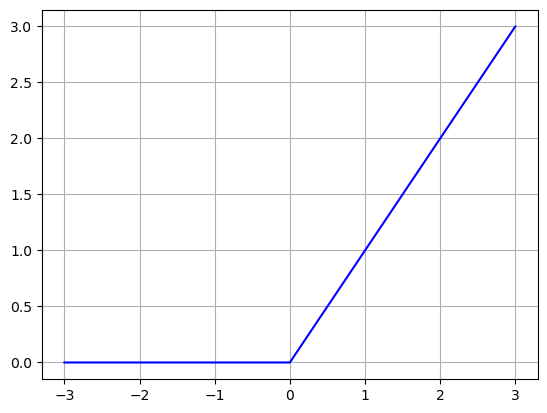

In [29]:
import matplotlib.pyplot as plt

reluFun = torch.nn.ReLU()
a = torch.linspace(-3,3,1000)
b = reluFun(a)
plt.figure()
plt.plot(a, b, 'blue')
plt.grid(True)


- sigmoid function: $$\sigma(x_i) = \frac{1}{1+e^{-x_i}}$$

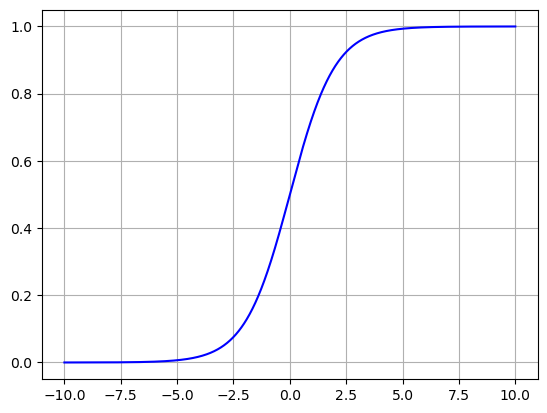

In [30]:
sigmoidFun = torch.nn.Sigmoid()
a = torch.linspace(-10,10,3000)
b = sigmoidFun(a)
plt.plot(a, b, 'blue')
plt.grid(True)

Alertness check: 

Suppose we would like to customize the sigmoid function by stretching/compressing or shifting.

a) How do we modify the sigmoid function to include a temperature argument ``tau`` where the sigmoid has a sharper transition (compressed) for smaller values of ``tau`` and slower (stretched) transition for larger values of ``tau``. Make sure your implementation is the same as conventional sigmoid for $\tau=1$.

b) Write an implementation of sigmoid that shifts the 0.5 probability point to an arbitrary location given by ``b``. Make sure your implementation is the same as conventional sigmoid for $b=0$.

Reminder - this is the sigmoid function: $$\sigma(x_i) = \frac{1}{1+e^{-\left(\frac{x_i}{\tau}-b\right)}}$$

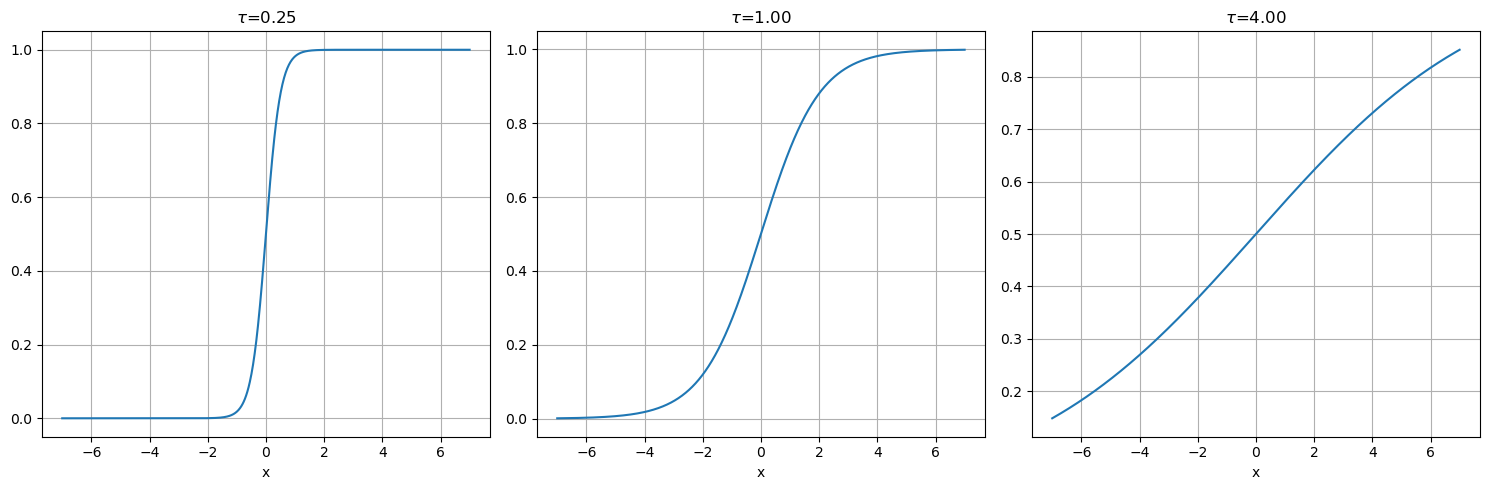

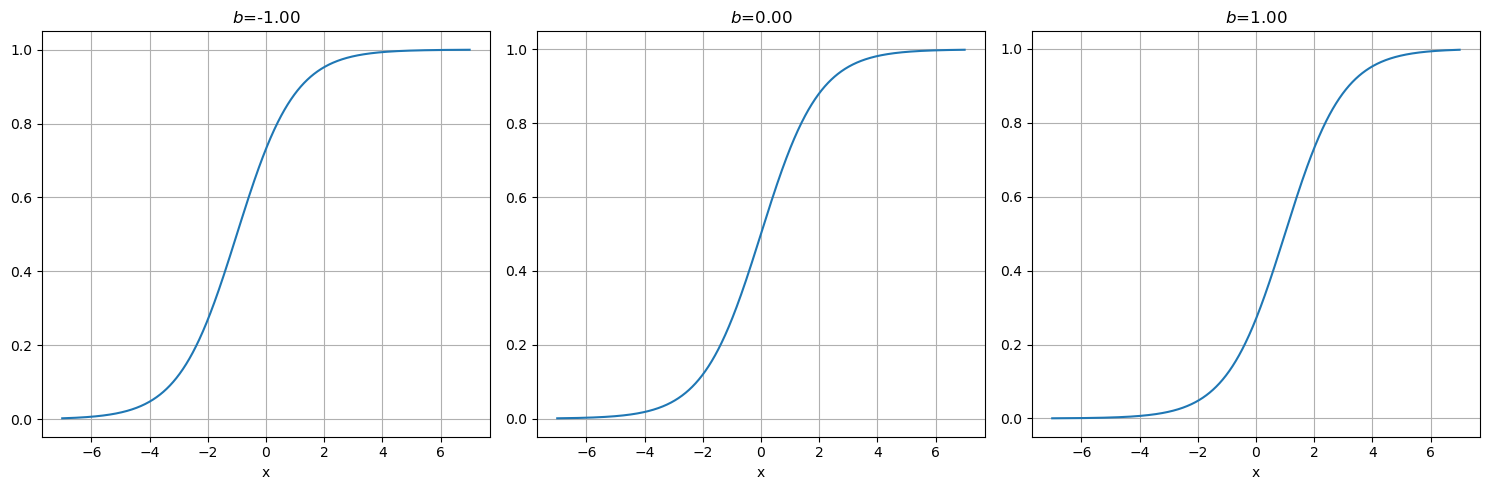

In [31]:
import torch

def my_sigmoid_a(x, tau):
    # write code to compute new sigmoid result using x and tau
    return 1/(1+torch.exp(-x/tau))

def my_sigmoid_b(x, b):
    # write code to compute new sigmoid result by centering about b
    return 1/(1+torch.exp(-(x-b)))

taus = [0.25, 1, 4]
x = torch.linspace(-7, 7, 1000)
# plot results
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.plot(x, my_sigmoid_a(x, taus[0]))
plt.title(r'$\tau$={:.2f}'.format(taus[0]))
plt.xlabel('x')
plt.grid(True)
plt.subplot(132)
plt.plot(x, my_sigmoid_a(x, taus[1]))
plt.title(r'$\tau$={:.2f}'.format(taus[1]))
plt.xlabel('x')
plt.grid(True)
plt.subplot(133)
plt.plot(x, my_sigmoid_a(x, taus[2]))
plt.title(r'$\tau$={:.2f}'.format(taus[2]))
plt.xlabel('x')
plt.grid(True)
plt.tight_layout()

centers = [-1, 0, 1]

plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.plot(x, my_sigmoid_b(x, centers[0]))
plt.title(r'$b$={:.2f}'.format(centers[0]))
plt.xlabel('x')
plt.grid(True)
plt.subplot(132)
plt.plot(x, my_sigmoid_b(x, centers[1]))
plt.title(r'$b$={:.2f}'.format(centers[1]))
plt.xlabel('x')
plt.grid(True)
plt.subplot(133)
plt.plot(x, my_sigmoid_b(x, centers[2]))
plt.title(r'$b$={:.2f}'.format(centers[2]))
plt.xlabel('x')
plt.grid(True)
plt.tight_layout()

Many functions in torch.nn also have a counterpart in torch.nn.functional (https://pytorch.org/docs/stable/nn.functional.html). 


Those functions just define the raw operation and all input arguments need to be passed (i.e., these functions don't have states). Typically ```torch.nn``` functions eventually call ```torch.nn.functional``` functions. So far we are looking at very basic functions. For those functions which have no inherent states there is hardly a difference (e.g., ```torch.nn.ReLU()(input)``` and ```torch.nn.functional.relu(input)```). But we can observe a first slight difference for the softmax function:

- softmax (dimension controls what $j$ we sum over/not really element-wise): $$\textrm{softmax}(x_i)=\frac{\exp(x_i)}{\sum_j\exp(x_j)}$$

In [32]:
softmaxFun = torch.nn.Softmax(dim=0)
a = torch.randn(2,4)
print('Original data:\n{}\n'.format(a))
b = torch.nn.functional.softmax(a,dim=0)
c = torch.nn.functional.softmax(a,dim=1)
d = softmaxFun(a)
print('Softmax along dimension 0 (columns sum to one):\n{}\n'.format(b))
print('Softmax along dimension 1 (rows sum to one):\n{}\n'.format(c))
print('Softmax along dimension 0 from Softmax object:\n{}\n'.format(d))

Original data:
tensor([[-1.2716,  1.7438, -0.8076,  0.8502],
        [-0.1469,  1.0274,  0.7231, -1.6251]])

Softmax along dimension 0 (columns sum to one):
tensor([[0.2451, 0.6718, 0.1779, 0.9224],
        [0.7549, 0.3282, 0.8221, 0.0776]])

Softmax along dimension 1 (rows sum to one):
tensor([[0.0319, 0.6510, 0.0508, 0.2663],
        [0.1460, 0.4723, 0.3484, 0.0333]])

Softmax along dimension 0 from Softmax object:
tensor([[0.2451, 0.6718, 0.1779, 0.9224],
        [0.7549, 0.3282, 0.8221, 0.0776]])



## Lecture Discussion: Why softmax?

Suppose we have a vector of $n$ real numbers given by $x\in\mathbb{R}^n$. We have defined softmax as
$$
\mathrm{softmax}(x)_i=\frac{e^{x_i}}{\sum_{j=1}^{n}e^{x_j}}
$$
where $\sum_{i}\mathrm{softmax}(x)_i = 1$ and thus softmax can convert any vector into a probability distribution while also making larger numbers correspond to larger probabilities. Why might we prefer softmax to the alternative below?
$$
\mathrm{LinearNormalize}(x)_i = \frac{x_i}{\sum_{j=1}^{n}x_j}
$$

**Answer**:

(1) Negative values in $x$ should not give negative probabilities

(2) Constant offsets to all elements in $x$ has no effect on softmax. In other words, we only need to care about the relative changes between elements in $x$.

## Derivatives of Basic Functions

What does the derivative of a scalar function tell us about the function?

- Slope of the function: Suppose we are given a differentiable function $f(x)$ depending on a scalar $x$, then the derivative $\frac{df}{dx}$ of the function $f$ at point $x$ is $$\frac{df}{dx} = \lim_{h\rightarrow 0}\frac{f(x+h)-f(x)}{h}$$

Let's use this to compute the derivative of $f(x) = x^2$: $$\lim_{h\rightarrow 0}\frac{(x+h)^2 - x^2}{h} = $$

$$= \lim_{h\rightarrow 0}\frac{2xh + h^2}{h} = $$

$$= \lim_{h\rightarrow 0} 2x + h = 2x$$

Using this we all derived and memorized many rules to "quickly" compute derivatives:
- $\frac{dx^p}{dx} = px^{p-1}$
- $\frac{d\exp(x)}{dx} = \exp(x)$
- $\frac{d\log(x)}{dx} = \frac{1}{x}$
- $\frac{d\sin(x)}{dx} = \cos(x)$

What if we have a composite function? E.g., $f(x) = \sin(\log(x^2 + 1))$. How to compute the derivative?

## Chain Rule

Compute the derivative of $f(x) = \sin(\log(x^2+1))$ by hand:

To do so we use the chain rule: $g(x) = x^2+1$, $h(g) = \log(g)$, $k(h) = \sin(h)$. Thus, $f(x) = k(h(g(x)))$

$$\frac{df}{dx} = \left.\frac{dk}{dh}\right|_{h(g)} \cdot \left.\frac{dh}{dg}\right|_{g(x)} \cdot \left.\frac{dg}{dx}\right|_x$$

$$\frac{df}{dx} = \cos(h(g)) \cdot \frac{1}{g(x)} \cdot 2x = \cos(\log(x^2+1)) \cdot \frac{1}{x^2+1} \cdot 2x= \frac{2x\cos(\log(x^2+1))}{x^2+1}$$

This can get very difficult and lengthy to compute very quickly. However, the problem of computing derivatives is very structured:

- first compute all the individual functions starting from the input variables ($x$ in our case for now) and keep them in mind. E.g., we decomposed $f(x) = \sin(\log(x^2+1))$ into: $$g(x) = x^2+1,~h(g) = \log(g),~k(h) = \sin(h)$$ and keep in mind values for $x$, $g$, $h$ and $k$.

**We will later call this the forward pass in a computation graph. Note that we can only compute the value of a function (node in the graph) once we have computed all its inputs, i.e., once we have values for all the children of a node.**

- then evaluate all the derivatives at the corresponding locations and multiply them together. For now this doesn't impose any order, i.e., we could evaluate the derivatives and conduct the multiplication in any order. However, once we consider more complex graphs we will see that the opposite order to the forward pass is ideal.

**We will later call this the backward pass in a computation graph. We can only compute the derivative of a node (function, variable, parameter) in a graph once we have the derivatives for its parents**

## Computation Graph

Consider again the function $f(x) = \sin(\log(x^2+1))$

For now we would need to manually implement the derivative $\cos(\log(x^2+1)) \cdot \frac{1}{x^2+1} \cdot 2x$. This is obviously very cumbersome. Whenever we change the function a little bit, we need to recompute the derivative and re-implement it again. This isn't very effective. PyTorch and other auto-differentiation tools provide much more effective ways to do this which we'll get to know later. For now we can investigate the computation graphs for the forward pass.

In [33]:
x = torch.Tensor([1])
x.requires_grad = True
g = x**2 + 1
h = torch.log(g)
k = torch.sin(h)
print('Is x a leaf node? {}'.format(x.is_leaf))
print('Is g a leaf node? {}'.format(g.is_leaf))
print('Is h a leaf node? {}'.format(h.is_leaf))
print('Is k a leaf node? {}'.format(k.is_leaf))
print('g: {}'.format(g))
print('h: {}'.format(h))
print('k: {}'.format(k))
print('x: {}'.format(x))

# manual derivative (gradient)
with torch.no_grad():
    manual = 2*x*torch.cos(torch.log(x**2+1))/(x**2+1)
# automatic derivative using backpropagation (more on this in future lectures!)
k.backward()
automatic = x.grad
print('Manually computed derivative from closed form: {}'.format(manual))
print('Letting PyTorch automatically find the derivative: {}'.format(automatic))

Is x a leaf node? True
Is g a leaf node? False
Is h a leaf node? False
Is k a leaf node? False
g: tensor([2.], grad_fn=<AddBackward0>)
h: tensor([0.6931], grad_fn=<LogBackward0>)
k: tensor([0.6390], grad_fn=<SinBackward0>)
x: tensor([1.], requires_grad=True)
Manually computed derivative from closed form: tensor([0.7692])
Letting PyTorch automatically find the derivative: tensor([0.7692])


## Visualizing computational graphs

Is there a way to visualize this computation graph?

Yes, for ```torch.nn.Modules```

In [34]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/experiment_1')
softmaxFun = torch.nn.Softmax(dim=1)
reluFun = torch.nn.ReLU()
tanhFun = torch.nn.Tanh()
graph = torch.nn.Sequential(tanhFun,reluFun,softmaxFun)
writer.add_graph(graph,torch.randn((5,7)))
writer.close()

ModuleNotFoundError: No module named 'tensorboard'

Open a tensorboard with the command ```$ tensorboard --logdir=runs``` and we should see the following graph:

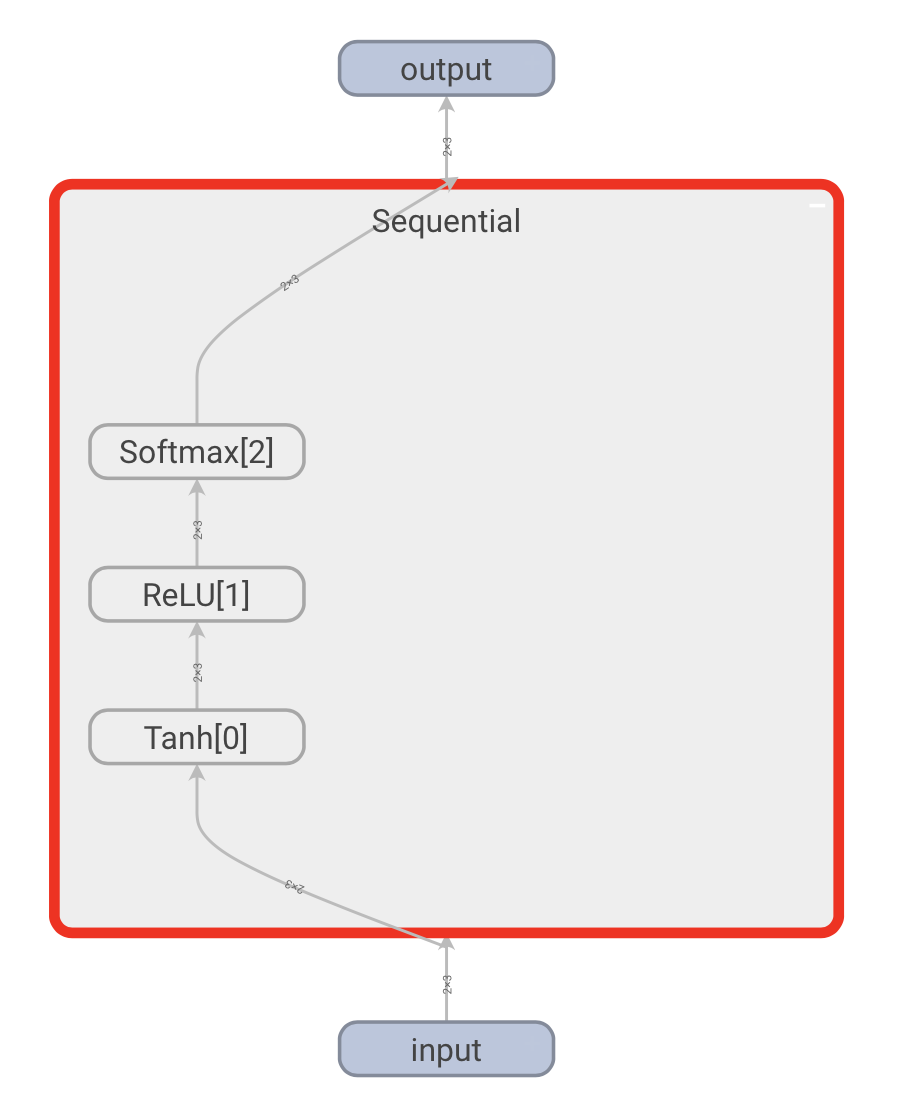

How can we define our own ```torch.nn.Module``` using functions that aren't part of torch.nn?

Answer: write our own module (don't worry about the exact formulation for now)

In [ ]:
import torch
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/experiment_2')
class OurNet(torch.nn.Module):
    def __init__(self):
        super(OurNet,self).__init__()
    def forward(self,x):
        g = x**2 + 1
        h = torch.log(g)
        k = torch.sin(h)
        return k
graph = OurNet()
writer.add_graph(graph,torch.randn((2,3)))
writer.close()

We'll obtain the following computation graph:

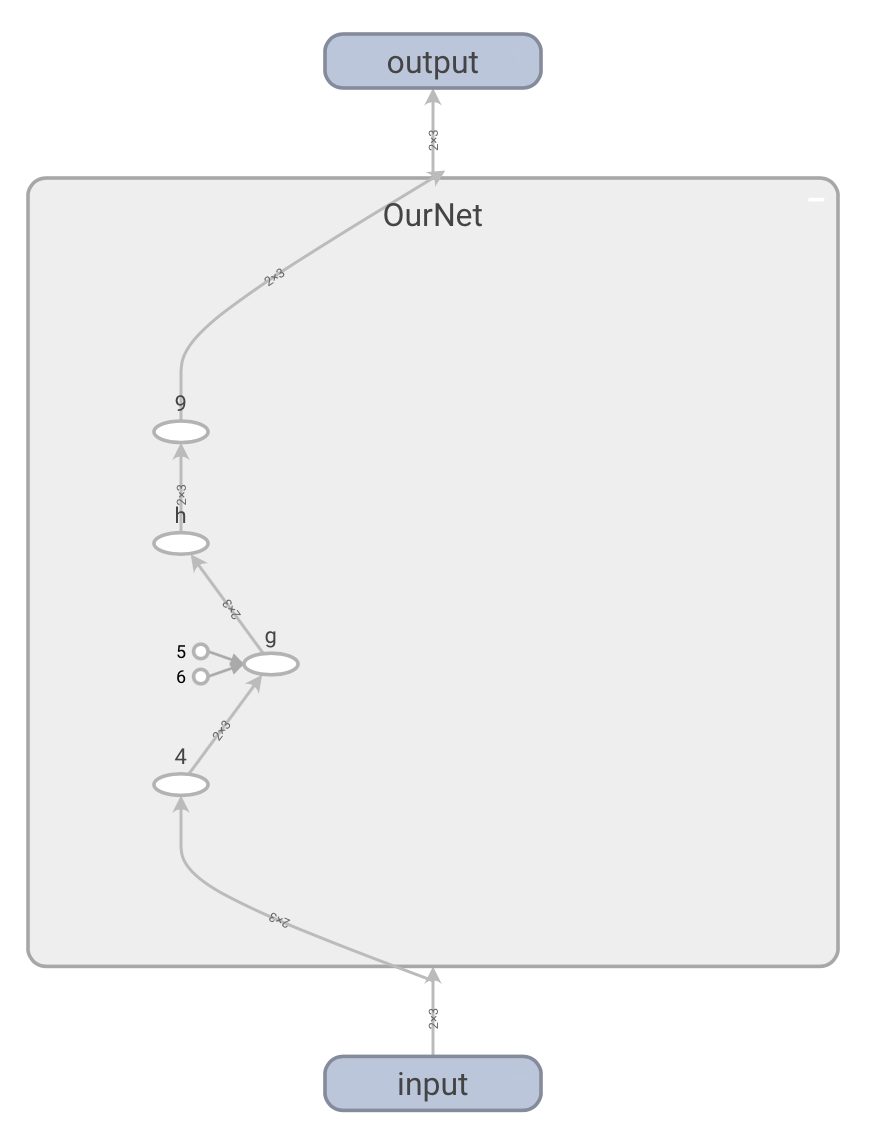

# Next week we will be discussing more linear algebra